In [5]:
# HIDDEN
Base.displaysize() = (5, 80)

## Apply, Strings, and Plotting

In this section, we will answer the question:

**Can we use the last letter of a name to predict the sex of the baby?**

Here's the Baby Names dataset once again:

In [1]:
using DataFrames
using CSV
baby = CSV.read("babynames.csv")
first(baby, 5)
# the first(df, n) method outputs the first n rows of the DataFrame df

,Name,Sex,Count,Year
,String,String,Int64,Int64
1,Mary,F,9217,1884
2,Anna,F,3860,1884
3,Emma,F,2587,1884
4,Elizabeth,F,2549,1884
5,Minnie,F,2243,1884


### Breaking the Problem Down

Although there are many ways to see whether prediction is possible, we will use plotting in this section. We can decompose this question into two steps:

1. Compute the last letter of each name.
1. Group by the last letter and sex, aggregating on Count.
1. Plot the counts for each sex and letter.

### The dot `.` operator

In Julia, you can use the dot `.` operator on `Arrays` to apply a function to each value in the `Array`. Let's check the length of the first 5 names:

In [2]:
names = baby.Name
print(length.(names)[1:5])

[4, 4, 4, 9, 6]

To extract the last letter of each name, we can define our own function to use it with the `.` operator:

In [3]:
function last_letter(string)
    return last(string)
end

print(last_letter.(names)[1:5])

['y', 'a', 'a', 'h', 'e']

We can now add this column of last letters to our `baby` DataFrame.

In [6]:
baby[!, :Last] = last.(names)
baby

,Name,Sex,Count,Year,Last
,String,String,Int64,Int64,Char
1,Mary,F,9217,1884,'y'
2,Anna,F,3860,1884,'a'
3,Emma,F,2587,1884,'a'
4,Elizabeth,F,2549,1884,'h'
5,Minnie,F,2243,1884,'e'
⋮,⋮,⋮,⋮,⋮,⋮


### Grouping

To compute the sex distribution for each last letter, we need to group by both Last and Sex. Once again we can use the `by()` function, and sort our result:

In [7]:
letter_distribution = by(baby, [:Last, :Sex], :Count => sum)
sort!(letter_distribution, [:Last, :Sex])
letter_distribution

,Last,Sex,Count_sum
,Char,String,Int64
1,'a',F,58079486
2,'a',M,1931630
3,'b',F,17376
4,'b',M,1435939
5,'c',F,30262
⋮,⋮,⋮,⋮


### Plotting

Plotting in Julia is available through external packages. [Plots](http://docs.juliaplots.org/latest/) is a popular package that provides backend APIs with different capabilities. [StatsPlots](https://github.com/JuliaPlots/StatsPlots.jl) is a replacement for `Plots` that has additional functionalities. It contains many statistical recipes and the convenience of plotting directly from table-like data structures (such as `DataFrames`).

Take your time to experiment the different functionalities that both packages provide, and visit the [docs](https://julialang.org/downloads/plotting.html) for more information.

Table-like data structures, including DataFrames, IndexedTables, DataStreams, etc... (see [here](https://github.com/queryverse/IterableTables.jl) for an exhaustive list), are supported thanks to the macro `@df` which allows passing columns as symbols. This way, to make a plot from our DataFrame `letter_distribution`, we can use the `@df` macro and pass the desired columns directly.

We use the `groupedbar` function for a bar plot:

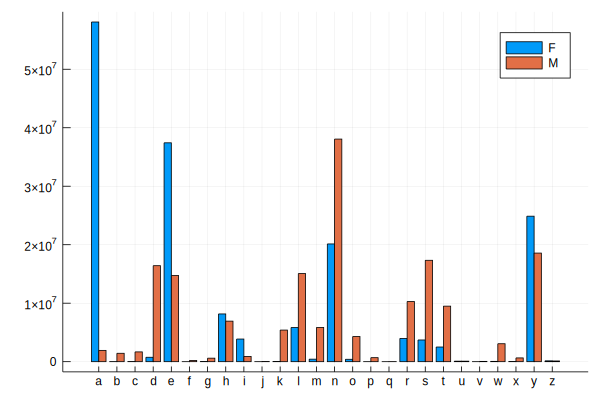

In [8]:
using StatsPlots
@df letter_distribution groupedbar(:Last, :Count_sum, group=:Sex, bar_position=:dodge)

Notice that `StatsPlots` conveniently generates a legend for us as well. However, this is difficult to interpret. We plot the counts for each letter and sex which causes some bars to appear very long and others to be almost invisible. We should instead plot the proportion of male and female babies within each last letter.

This process is similar to what was done in chapter 1. First we break down the counts for each letter, and compute the total by using [`map`](https://docs.julialang.org/en/v1/base/collections/#Base.map). This function transforms a collection by applying a function to each element in that collection. In this case, we pass the sum of each letter to obtain the total:

In [9]:
letter_distribution.X1 = ifelse.(letter_distribution.Sex .== "F", letter_distribution.Count_sum, 0)
letter_distribution.X2 = ifelse.(letter_distribution.Sex .== "M", letter_distribution.Count_sum, 0)

proportion_by_letter = by(letter_distribution, :Last, F = :X1 => sum, M = :X2 => sum)
proportion_by_letter.Total = map((x, y) -> x + y, proportion_by_letter.F, proportion_by_letter.M)

proportion_by_letter

,Last,F,M,Total
,Char,Int64,Int64,Int64
1,'a',58079486,1931630,60011116
2,'b',17376,1435939,1453315
3,'c',30262,1672407,1702669
4,'d',754233,16412640,17166873
5,'e',37421616,14730974,52152590
⋮,⋮,⋮,⋮,⋮


Now we can easily calculate the porportion for each letter:

In [10]:
proportion_by_letter.F_prop = map((x, y) -> x / y, proportion_by_letter.F, proportion_by_letter.Total)
proportion_by_letter.M_prop = map(x -> 1 - x, proportion_by_letter.F_prop)

proportion_by_letter

,Last,F,M,Total,F_prop,M_prop
,Char,Int64,Int64,Int64,Float64,Float64
1,'a',58079486,1931630,60011116,0.967812,0.0321879
2,'b',17376,1435939,1453315,0.0119561,0.988044
3,'c',30262,1672407,1702669,0.0177733,0.982227
4,'d',754233,16412640,17166873,0.0439354,0.956065
5,'e',37421616,14730974,52152590,0.717541,0.282459
⋮,⋮,⋮,⋮,⋮,⋮,⋮


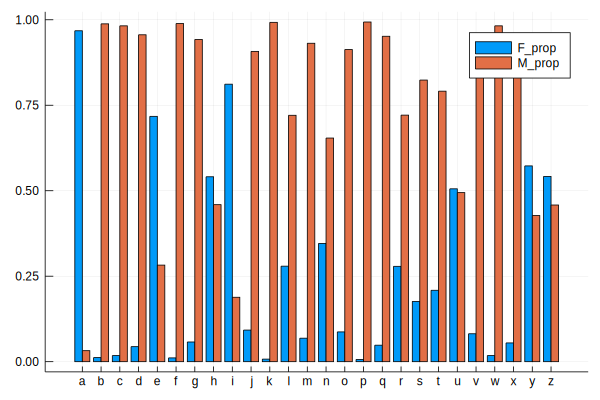

In [11]:
@df proportion_by_letter groupedbar(:Last, [:F_prop :M_prop])

## In Conclusion

We can see that almost all first names that end in 'p' are male and names that end in 'a' are female! In general, the difference between bar lengths for many letters implies that we can often make a good guess to a person's sex if we just know the last letter of their first name.

We've learned to express the following operations in `Julia`:

| Operation | `Julia` |
| --------- | -------  |
| Applying a function elementwise | `.` operator |
| Plotting from a DataFrame using `StatsPlots`| `@df df_name plot_function()` |
| Transform a collection c with function f | `map(f, c)` |